## Convocatoria 1 - Proyecto 1

In [117]:
from skimage import io, morphology
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage.morphology import binary_fill_holes as bfh
from skimage.morphology import convex_hull_image
from skimage.measure import label 
from skimage.measure import regionprops

#### 0) Cargar una de las imágenes histológicas

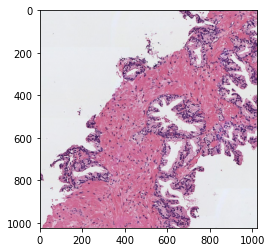

In [88]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img = io.imread('histo_1.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
rgb = img.copy()
rgb_p = rgb.astype('uint8')/255

# Visualizar la imagen
plt.imshow(rgb_p, cmap='gray') #cmap es el mapa de color
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

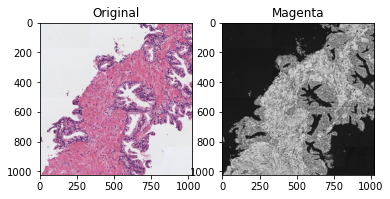

In [196]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)

# Realizamos una conversion de RGB a CMYK
# El np.errstate evitar errores matematicos
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(rgb_p, axis=2)
    # Extrae los canales de acuerdo con la ecuación del power point
    C = (1-rgb[:,:,0]-K)/(1-K)
    M = (1-rgb[:,:,1]-K)/(1-K)
    Y = (1-rgb[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)))

# En CMYK tengo todos juntos, con split se separan
C,M,Y,K = cv2.split(CMYK)

# Visualizamos el color magenta
fig, ax = plt.subplots(1,2)
ax[0].imshow(rgb_p, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(M.astype('uint8'), cmap='gray'), ax[1].set_title('Magenta')
#ax[1].imshow(M, cmap='gray'), ax[1].set_title('Magenta')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

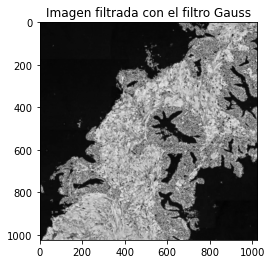

[0 1]


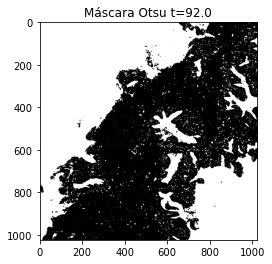

In [197]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

# Aplicamos un filtro gaussiano para emborronar las altas frecuencias
M_gauss = cv2.GaussianBlur(M.astype('uint8'), (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.title('Imagen filtrada con el filtro Gauss')
plt.imshow(M_gauss, cmap='gray')
plt.show()

# Fijamos el umbral con el método de OTSU
t, mask = cv2.threshold(M_gauss,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask))

# Invertimos los colores
mask_otsu = -1 * mask + np.ones(len(mask)).astype('uint8')

# Visualizamos para compobrar que se obtiene el mismo resultado
plt.imshow(mask_otsu, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

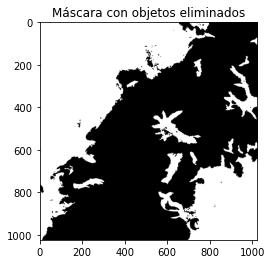

In [93]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

# Convertimos la máscara anterior a booleanos
mask_arr= np.array(mask_otsu, bool)

# Le pasamos a la funcion de eliminar objetos el array de booleanos y el tamaño minimo de los objetos
mask_limpia = morphology.remove_small_objects(mask_arr, min_size=300, connectivity=1, in_place=False)

# Visualizamos para comprobar el resultado
plt.imshow(mask_limpia, cmap='gray')
plt.title('Máscara con objetos eliminados')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

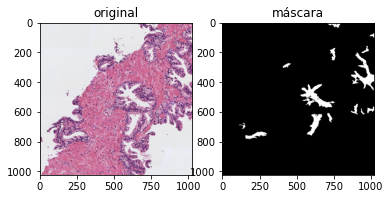

In [94]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

# Crear una copia de la imagen
mask_rellena = mask_limpia.copy().astype('uint8')

# Definir una imagen negra de referencia
h,w = mask_limpia.shape
ref = np.zeros((h+2, w+2), np.uint8)


# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
# Y en la otra esquina (1000,1000)
# Metodo floodfill: imagen, la referencia, semilla (00), relleno con 0
cv2.floodFill(mask_rellena, ref, (0,0), 0) # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(mask_rellena, ref, (1000,1000), 0)

# Visualizamos para comprobar el resultado
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask_rellena, cmap='gray'), ax[1].set_title('máscara')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

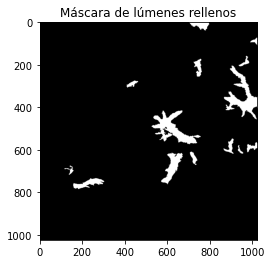

In [106]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology

# Con la funcion bhf rellena huecos de imagenes binarias (objetos cerrados)
mask_filled_bordes = bfh(mask_rellena.astype('uint8'))

# Visualizar la máscara resultante
plt.imshow(mask_filled_bordes.astype('uint8'), cmap='gray')
plt.title('Máscara de lúmenes rellenos')
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

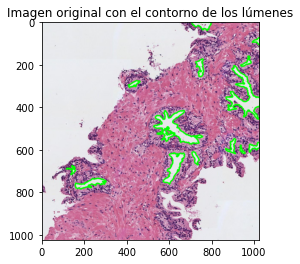

In [110]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 


#findcontours, encontrar contornos (no detectar como canny) de los objetos de la mascara y draw los dibuja
conts,_ = cv2.findContours(mask_filled_bordes.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Encontramos los contornos en una máscara 
imagen = cv2.drawContours(img.copy(), conts, -1, (0,255,0), 5) # Dibujamos los contornos
  
# Visualizar la imagen superpuesta
plt.imshow(imagen, cmap='gray')
plt.title('Imagen original con el contorno de los lúmenes')
plt.show()


#### 7) Identificar y cropear el lumen más grande

Número de objetos:  14
Posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


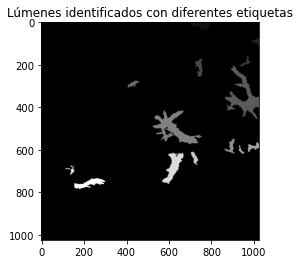

Áreas de los diferentes lúmenes: [2236, 618, 761, 1709, 12288, 825, 12457, 1292, 1141, 350, 1001, 5959, 486, 3335]
Lúmen con mayor área:  [6]  con un valor de:  12457


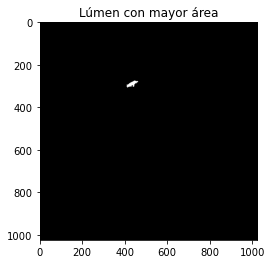

Coordenadas de la bounding box:  (275, 405, 308, 461)


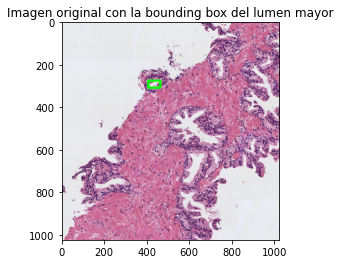

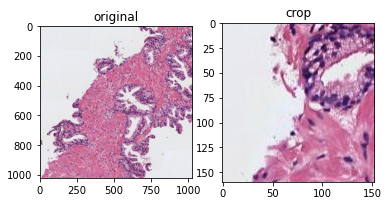

In [156]:
# Para saber cual es el lumen ms grande, etiquetamos con label, los objetos diferentes, independientes
# Asi poder accedeer a cada elemento por su etiqueta
lab, num = label(mask_filled_bordes, return_num=True)

# Importante:
# En 'num' devuelve 14 valores correspondientes a los 14 objetos que hay en la imagen.
# Sin embargo, 'lab' contiene hasta 15 valores diferentes, ya que también tiene en cuenta el fondo de la imagen.
print('Número de objetos: ', num)
v, c = np.unique(lab, return_counts=True)
print('Posibles valores de intensidad: ', v)

plt.imshow(lab, cmap='gray')
plt.title('Lúmenes identificados con diferentes etiquetas')
plt.show()

# Determinar cuál es el lumen de mayor área 
A = []

for i in range(1,num + 1):
    objeto = lab == i
    prop = regionprops(objeto.astype(np.uint8))
    A.append(np.round(prop[0].area, 4))
    
print('Áreas de los diferentes lúmenes:', A)
print('Lúmen con mayor área: ', np.where(A == np.max(A))[0], ' con un valor de: ', np.max(A))

# Mostramos el lumen con mayor área
lumen_mayor = lab == np.where(A == np.max(A))[0]
lumen_mayor= lumen_mayor.astype('uint8')
plt.title('Lúmen con mayor área')
plt.imshow(lumen_mayor, cmap='gray')
plt.show()
    

# Extraemos la bounding box de dicho objeto 
prop = regionprops(lumen_mayor)

#Saco la bounding box
bbox = prop[0].bbox

#Me genera las coordenadas del cuadrado
print('Coordenadas de la bounding box: ', bbox)

# Eso sirve para pintarla
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img.copy(), start_point, end_point, (0, 255, 0), 10) #image, empiece, acabar, color, grosor
                 
plt.imshow(window, cmap='gray')
plt.title('Imagen original con la bounding box del lumen mayor')
plt.show()


# Hacer un crop del mismo sobre la imagen original RGB.
# Cojo los pixeles que quiero, es 'recortar'.
new_img = img[bbox[0]-30:bbox[1], bbox[2]:bbox[3]]

# Visualizar el lumen cropeado.
figs, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(new_img, cmap='gray'), ax[1].set_title('crop')
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área

# 2) Área de la bounding box

# 3) Área convexa

# 4) Exentricidad

# 5) Diámetro equivalente

# 6) Extensión

# 7) Diámetro Feret

# 8) Longitud del eje mayor

# 9) Longitud del eje menor

# 10) Orientación

# 11) Perímetro

# 12) Solidez

# 13) Compacidad
